# pre_Data-Format
### Step_1. FormatOfficial2Yolo

In [13]:
!python Code/pre_FormatOfficial2Yolo.py

1. Renaming Training Dataset_v5 --> Origin_Training_Dataset
2. Backing-up Labels to Dataset/Origin_Training_Dataset/origin_labels/...
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 891.24it/s]
3. Formatting Official Labels to yolo Type...
100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.30it/s]
4. Moving Labels to Dataset/Origin_Training_Dataset/labels...
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1710.07it/s]
5. Moving images to Dataset/Origin_Training_Dataset/images...
6. Start Splitting 10% of Training Data to Val Data...
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 842.31it/s]


# train_Model-Baseline
### Step_2-1. Baseline model train

In [14]:
# move the code we change in YOLOv5
!cp Code/yolov5l6.yaml yolov5/yolov5l6.yaml
!cp Code/dataset-Origin_Training_Dataset.yaml yolov5/dataset-Origin_Training_Dataset.yaml
!cp Code/hyp.none.yaml yolov5/hyp.none.yaml

# training
!python -m torch.distributed.run --nproc_per_node 2 yolov5/train.py --weights yolov5/yolov5l6.pt --cfg yolov5/yolov5l6.yaml --hyp yolov5/hyp.none.yaml --data yolov5/dataset-Origin_Training_Dataset.yaml --epochs 1000 --batch-size 8 --imgsz 1920 --device 0,1 --patience 50

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
train: weights=yolov5/yolov5l6.pt, cfg=yolov5/yolov5l6.yaml, data=yolov5/dataset-Origin_Training_Dataset.yaml, hyp=yolov5/hyp.none.yaml, epochs=1000, batch_size=8, imgsz=1920, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0,1, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=F

### Step_2-2. Baseline model detect (Public 0.70)

In [15]:
!python yolov5/detect.py --data yolov5/dataset-Origin_Training_Dataset.yaml --imgsz 1080 1920 --save-txt --save-conf --weight yolov5/runs/train/exp/weights/best.pt --source Dataset/public
# If you skip training you can simply run the following line
# !python yolov5/detect.py --data yolov5/dataset-Origin_Training_Dataset.yaml --imgsz 1080 1920 --save-txt --save-conf --weight Dataset/Models/baseline.pt --source Dataset/public

detect: weights=['yolov5/runs/train/exp/weights/best.pt'], source=Dataset/public, data=yolov5/dataset-Origin_Training_Dataset.yaml, imgsz=[1080, 1920], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
YOLOv5 🚀 2022-12-14 Python-3.8.15 torch-1.13.0+cu117 CUDA:0 (NVIDIA A100-PCIE-40GB, 40536MiB)

Fusing layers... 
YOLOv5l6 summary: 346 layers, 76141740 parameters, 0 gradients,

In [16]:
!python Code/post_FormatYolo2Official.py

1. Renaming public --> Origin_Pubic_Dataset
2. Renaming Private Testing Dataset_v2 --> Origin_Private_Dataset
3. Start Transforming exp to Official Answer Format...
4. Saving exp Official Format Answer in Output/


# pre_Data-Cleaning
### Step_3. Analyze bbox
### Mistaken bbox

min = 0 ; max = 87655 ; mean = 1703.0942665575003 ; length = 45191


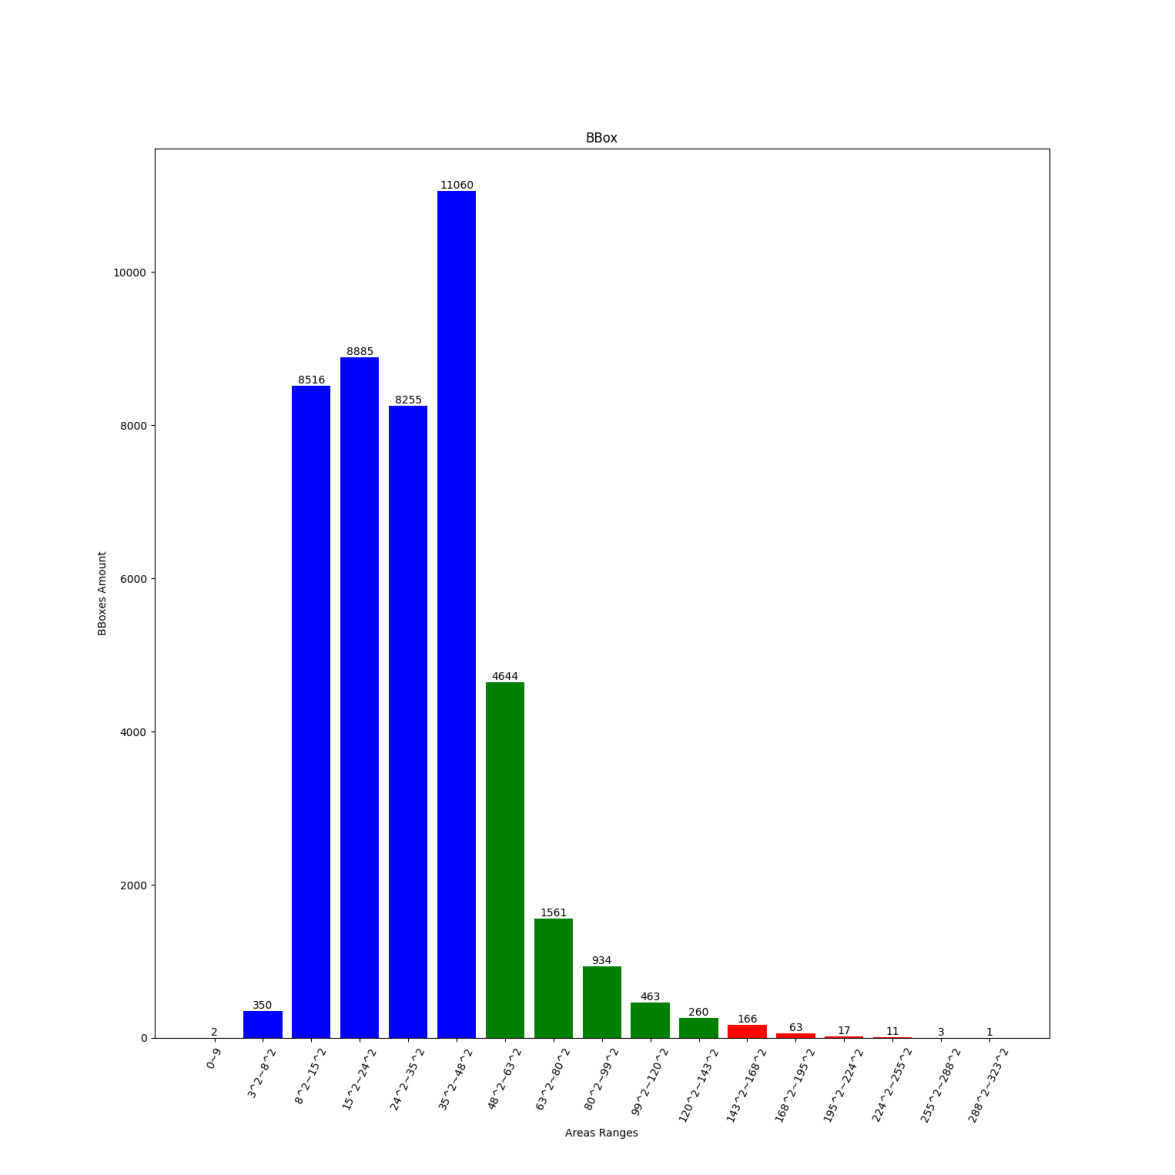

In [17]:
!python Code/pre_AnalyzeBBox_Mistaken.py

import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(cv2.imread('Output/AnalyzeBBox_Mistaken.png'))

### Outlier bbox


In [18]:
!python Code/pre_AnalyzeBBox_Outlier.py

There may be incorrect labels        car in img0004.txt with max area  3060
There may be incorrect labels        car in img0023.txt with max area  2440
There may be incorrect labels        hov in img0028.txt with max area 13272
There may be incorrect labels        car in img0036.txt with max area  2805
There may be incorrect labels        hov in img0050.txt with max area  9108
There may be incorrect labels        car in img0054.txt with max area   442
There may be incorrect labels        hov in img0057.txt with max area  4674
There may be incorrect labels motorcycle in img0060.txt with max area  2772
There may be incorrect labels        car in img0062.txt with max area  2350
There may be incorrect labels motorcycle in img0065.txt with max area  2277
There may be incorrect labels     person in img0072.txt with max area   990
There may be incorrect labels        car in img0073.txt with max area  7930
There may be incorrect labels        car in img0080.txt with max area  3016
There may be

# pre_Data-Classify
### Step_4. Classify bbox with size
### K-means


Reading car BBoxes files...
There are 960 car mean BBoxes.
Plotting... 
/home/student/yueh_huangje_2022/.conda/envs/drone_test/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|████████████████████████████████████████| 960/960 [00:01<00:00, 583.27it/s]

Reading hov BBoxes files...
There are 605 hov mean BBoxes.
Plotting... 
/home/student/yueh_huangje_2022/.conda/envs/drone_test/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|████████████████████████████████████████| 605/605 [00:00<00:00, 630.42it/s]

Reading person BBoxes files...
There are 661 person mean BBoxes.
Plotting... 
/home/student/yueh_huangje_2022/.conda/envs/drone_test/lib/py

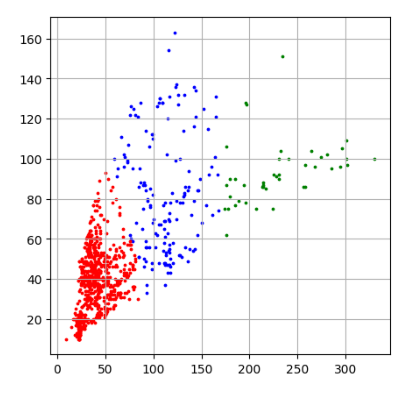

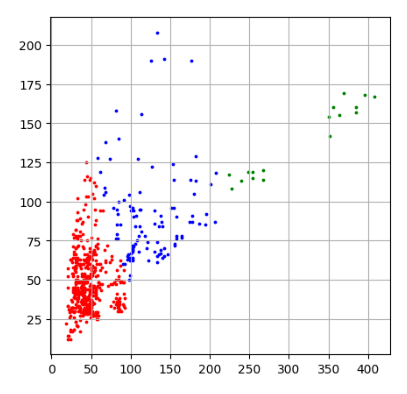

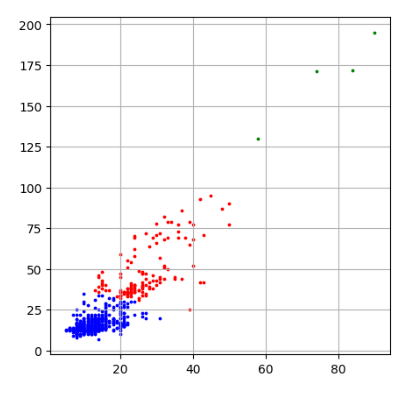

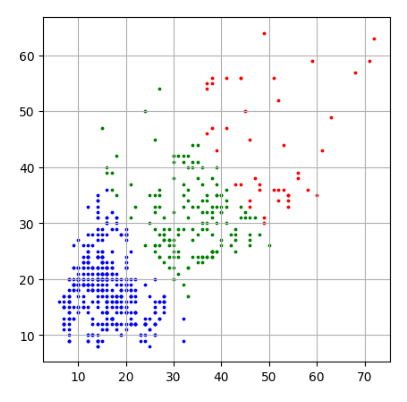

In [19]:
!python Code/pre_AnalyzeBBox_kmeans.py

import matplotlib.pyplot as plt
Classes = ['car', 'hov', 'person', 'motorcycle']

for Class in Classes:
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(cv2.imread(f'Output/AnalyzeBBox_3-means_{Class}.png'))

# pre_Data-Cleaning
### Step_5. Compare GT bbox with baseline prediction

In [ ]:
# Just simply download the labels we already re-labeled.

# How we re-labeled:
# 1. Detect training dataset with baseline.pt
# 2. Preserve the prediction's boundingboxes which have an IoU > 0.5 boundingbox in origin training dataset
#    (why? Because the prediction boundingboxes' quality is better than human-labelling, which can avoid being insufficient or exceed the object seriously.)
# 3. Compare remaining prediction's boundingboxes one-by-one with my human eye

# pre_Data-SuperResolution
### Step_6. Resize images 2 times larger


In [ ]:
# Just simply download the images we super-resolved.

### Step_7. Resize all images to 3840x2160 with Bicubic

In [21]:
!python Code/pre_ResizeSuperResolution.py

Super-resolving all images to 3840x2160...
100%|███████████████████████████████████████| 2000/2000 [07:42<00:00,  4.33it/s]


# pre_Data-Cleaning
### Step_8. Filter out the ignored areas

In [22]:
!python Code/pre_FilterIgnoredAreas.py

100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 33.20it/s]


# pre_Data-Slicing
### Step_9. Slice Super Resolution images (3840x2160 --> 832x832)

In [29]:
# Create COCO format for slicing
!python Code/pre_FormatYolo2Coco.py  --path Dataset/SuperResolution_Training_Dataset

# Start slicing...
!python Code/pre_Slicing.py

Start!
Processing 999 ...Finished!
indexing coco dataset annotations...
100%|███████████████████████████████████████| 1000/1000 [08:55<00:00,  1.87it/s]


# pre_Data-Augmentation
### Step_11. Augmentation

In [1]:
# move the code we change in MMDetection
!cp Code/mm__init__.py mmdetection/mmdet/datasets/pipelines/__init__.py
!cp Code/browse_dataset.py mmdetection/tools/misc/browse_dataset.py
!cp Code/image.py mmdetection/mmdet/core/visualization/image.py
!cp Code/SmallObjectAugmentation.py mmdetection/mmdet/datasets/pipelines/SmallObjectAugmentation.py
!cp Code/transforms.py mmdetection/mmdet/datasets/pipelines/transforms.py
!cp Code/dataset_visualize.py mmdetection/dataset_visualize.py

# install mmdetection
!pip install -U openmim
!mim install mmcv-full
# !cd mmdetection
!pip install -v -e mmdetection


import os

if not os.path.exists('Dataset/SuperResolution_Training_Sliced_Augmentation'):
    os.mkdir('Dataset/SuperResolution_Training_Sliced_Augmentation')


!python mmdetection/tools/misc/browse_dataset.py mmdetection/dataset_visualize.py --output-dir Dataset/SuperResolution_Training_Sliced_Augmentation/ --not-show

/home/student/yueh_huangje_2022/.conda/envs/drone_test/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
Using pip 22.3.1 from /home/student/yueh_huangje_2022/.conda/envs/drone_test/lib/python3.8/site-packages/pip (python 3.8)
Obtaining file:///home/student/yueh_huangje_2022/Competition/mmdetection
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-a_4bxu8u/mmdet.egg-info
  writing /tmp/pip-pip-egg-info-a_4bxu8u/mmdet.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-a_4bxu8u/mmdet.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-a_4bxu8u/mmdet.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-a_4bxu8u/mmdet.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-inf

# train_Model-832x832
### Step_12-1. 832x832 model train


In [6]:
import glob
import random
from tqdm import tqdm
import os

print('Start Splitting 10% of Training Data to Val Data...')
TrainingDatasetRoot = 'Dataset/SuperResolution_Training_Sliced_Augmentation/'

ImagesList = sorted(glob.glob(f'{TrainingDatasetRoot}*.jpg'))
LabelsList = sorted(glob.glob(f'{TrainingDatasetRoot}*.txt'))

os.mkdir(f'{TrainingDatasetRoot}images')
os.mkdir(f'{TrainingDatasetRoot}labels')
os.mkdir(f'{TrainingDatasetRoot}images/train')
os.mkdir(f'{TrainingDatasetRoot}labels/train')
os.mkdir(f'{TrainingDatasetRoot}images/val')
os.mkdir(f'{TrainingDatasetRoot}labels/val')

for file in ImagesList:
    os.rename(file, f'{TrainingDatasetRoot}images/train/' + file.split('/')[-1])
for file in LabelsList:
    os.rename(file, f'{TrainingDatasetRoot}labels/train/' + file.split('/')[-1])

ImagesList = sorted(glob.glob(f'{TrainingDatasetRoot}images/train/*.jpg'))

val_index = random.sample(range(1, 18000), 1800)
for index in tqdm(val_index):
    name = ImagesList[index].split('/')[-1].split('.')[0]
    os.rename(f'{TrainingDatasetRoot}images/train/{name}.jpg',
              f'{TrainingDatasetRoot}images/val/{name}.jpg')
    os.rename(f'{TrainingDatasetRoot}labels/train/{name}.txt',
              f'{TrainingDatasetRoot}labels/val/{name}.txt')

Start Splitting 10% of Training Data to Val Data...


100%|██████████| 1800/1800 [00:02<00:00, 883.80it/s]


In [ ]:
!cp Code/dataset-SuperResolution_Training_Sliced_Augmentation.yaml yolov5/dataset-SuperResolution_Training_Sliced_Augmentation.yaml
!cp Code/hyp.high_custom.yaml yolov5/hyp.high_custom.yaml

print('Start training...')
#training
!python -m torch.distributed.run --nproc_per_node 2 yolov5/train.py --weights yolov5/yolov5l6.pt --cfg yolov5/yolov5l6.yaml --hyp yolov5/hyp.high_custom.yaml --data yolov5/dataset-SuperResolution_Training_Sliced_Augmentation.yaml --epochs 1000 --batch-size 20 --imgsz 1664 --device 0,1 --patience 50

Start training...
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
train: weights=yolov5/yolov5l6.pt, cfg=yolov5/yolov5l6.yaml, data=yolov5/dataset-SuperResolution_Training_Sliced_Augmentation.yaml, hyp=yolov5/hyp.high_custom.yaml, epochs=1000, batch_size=20, imgsz=1664, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0,1, multi_scale=Fa

### Step_12-2. 832x832 model detect (Public 0.724934 / Private 0.753749)

In [ ]:
!cp -R Dataset/SuperResolution_Public_Dataset/*.png Dataset/SuperResolution_PublicPrivate_Dataset/

!python yolov5/detect.py --data yolov5/dataset-SuperResolution_Training_Sliced_Augmentation.yaml --imgsz 3072 5376 --save-txt --save-conf --weight yolov5/runs/train/exp2/weights/best.pt --source Dataset/SuperResolution_PublicPrivate_Dataset --augment --conf-thres 0.4
# If you skip training you can simply run the following line
# !python yolov5/detect.py --data yolov5/dataset-SuperResolution_Training_Sliced_Augmentation.yaml --imgsz 3072 5376 --save-txt --save-conf --weight Dataset/Models/832x832.pt --source Dataset/SuperResolution_PublicPrivate_Dataset --augment --conf-thres 0.4

In [ ]:
!python Code/post_FormatYolo2Official.py

### Step_12-2. 832x832 model detect WBF with Baseline model (Public 0.725854 / Private 0.754987)
# This is a mysterious step, but it made the highest score !


In [ ]:
# Detect the super-resolved public and private images with baseline model first
!python yolov5/detect.py --data yolov5/dataset-Origin_Training_Dataset.yaml --imgsz 3072 5376 --save-txt --save-conf --weight yolov5/runs/train/exp/weights/best.pt --source Dataset/SuperResolution_PublicPrivate_Dataset --augment --conf-thres 0.4
# If you skip training you can simply run the following line
# !python yolov5/detect.py --data yolov5/dataset-Origin_Training_Dataset.yaml --imgsz 3072 5376 --save-txt --save-conf --weight Dataset/Models/baseline.pt --source Dataset/SuperResolution_PublicPrivate_Dataset --augment --conf-thres 0.4

In [ ]:
# WBF the result of 832x832 model and baseline model with weights of 1.3 : 1
!python Code/post_WBF.py

In [ ]:
!python Code/post_FormatYolo2Official.py
